# LSTM

## Load models

In [5]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from utils import *
import os

os.chdir('C:/Users/howar/Desktop/Coursework/ME4-Individual-Project-Volatility-Forecasting')

In [2]:
lstm_model = load_model('models/LSTM.h5')
lstm_sent_model = load_model('models/LSTM Sentiment.h5')
lstm_yield_model = load_model('models/LSTM Yield.h5')
lstm_combined_model = load_model('models/LSTM Sentiment Yield.h5')

##  Data processing

In [3]:
r = pd.read_csv('data/intraday_returns.csv', index_col=0, parse_dates=True)
sentiment = pd.read_csv('data/sentiment_features.csv', index_col=0, parse_dates=True)
yc = pd.read_csv('data/yield_curves.csv', index_col=0, parse_dates=True)

# Compute covariance
cov = compute_covariance(r)

# Match dates
yc = yc[yc.index.isin(cov.index.get_level_values(0))]
cov = cov[cov.index.get_level_values(0).isin(yc.index.date)]
sentiment = sentiment[sentiment.index.isin(cov.index.get_level_values(0))]

# Compute covariance vectors
N = len(r.columns)
cov_vectors = decompose_covariance(cov.values.reshape((-1, N, N)))

# Create sequences
window = 60
Xcov, Xsent, Xyield, y = [], [], [], []

for i in range(len(cov_vectors) - window):
    Xcov.append(cov_vectors[i:i + window])
    Xsent.append(sentiment.iloc[i:i + window].values)
    Xyield.append(yc.iloc[i:i + window].values)
    y.append(cov_vectors[i + window])

Xcov = np.array(Xcov)
Xsent = np.array(Xsent)
Xyield = np.array(Xyield)
y = np.array(y)

Xcov.shape, Xsent.shape, Xyield.shape, y.shape

((2188, 60, 78), (2188, 60, 12), (2188, 60, 11), (2188, 78))

In [6]:
r_test = pd.read_csv('data/daily_returns_test.csv', index_col=0, parse_dates=True)
test_window = len(r_test)

# We are only interested in the test data
_, Xcov_test, _, y_test = train_test_split(Xcov, y, test_size=test_window, shuffle=False)
_, Xsent_test = train_test_split(Xsent, test_size=test_window, shuffle=False)
_, Xyield_test = train_test_split(Xyield, test_size=test_window, shuffle=False)

## Perform predictions and calculate errors

In [9]:
lstm_pred = lstm_model.predict(Xcov_test)
sent_pred = lstm_sent_model([Xcov_test, Xsent_test])
yield_pred = lstm_yield_model([Xcov_test, Xyield_test])
combined_pred = lstm_combined_model([Xcov_test, Xsent_test, Xyield_test])

In [10]:
def mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

lstm_mse = mse(y_test, lstm_pred)
sent_mse = mse(y_test, sent_pred)
yield_mse = mse(y_test, yield_pred)
combined_mse = mse(y_test, combined_pred)

lstm_mse, sent_mse, yield_mse, combined_mse

(5.721840324564198e-05, 5.8536658e-05, 5.525573e-05, 5.1866806e-05)

| Model | MSE |
| :- | :- |
| LSTM | 5.72e-5 |
| LSTM Sentiment | 5.85e-5 |
| LSTM Yield Curve| 5.53e-5 |
| **LSTM Sentiment + Yield Curve**| **5.19e-5** |

## Assess portfolio performance

In [11]:
# First reconstruct covariance matrix from vectors
cov_lstm, cov_sent, cov_yield, cov_comb = [], [], [], []

for i in range(len(lstm_pred)):
    cov_lstm.append(reconstruct_covariance(lstm_pred[i]))
    cov_sent.append(reconstruct_covariance(sent_pred[i]))
    cov_yield.append(reconstruct_covariance(yield_pred[i]))
    cov_comb.append(reconstruct_covariance(combined_pred[i]))
    
cov_lstm, cov_sent, cov_yield, cov_comb = np.array(cov_lstm), np.array(cov_sent), np.array(cov_yield), np.array(cov_comb) 

In [19]:
# Create individual portfolios and print performance metrics
print('LSTM Portfolio:')
lstm_port = Portfolio(r_test, cov_lstm)
lstm_port.optimize()
lstm_port.metrics(plot_history=False)

print()

print('LSTM Sentiment Portfolio:')
sent_port = Portfolio(r_test, cov_sent)
sent_port.optimize()
sent_port.metrics(plot_history=False)

print()

print('LSTM Yield Curve Portfolio:')
yield_port = Portfolio(r_test, cov_yield)
yield_port.optimize()
yield_port.metrics(plot_history=False)

print()

print('LSTM Sentiment + Yield Curve Portfolio:')
comb_port = Portfolio(r_test, cov_comb)
comb_port.optimize()
comb_port.metrics(plot_history=False)

LSTM Portfolio:
Final Portfolio Value: $122.6
Overall Return (%): 22.58
Sharpe Ratio: 2.06
Sortino Ratio: 2.7

LSTM Sentiment Portfolio:
Final Portfolio Value: $123.9
Overall Return (%): 23.88
Sharpe Ratio: 2.12
Sortino Ratio: 2.88

LSTM Yield Curve Portfolio:
Final Portfolio Value: $119.9
Overall Return (%): 19.87
Sharpe Ratio: 1.83
Sortino Ratio: 2.43

LSTM Sentiment + Yield Curve Portfolio:
Final Portfolio Value: $120.7
Overall Return (%): 20.67
Sharpe Ratio: 1.93
Sortino Ratio: 2.56


The LSTM Sentiment model had the best overall performance. The yield curve models have the worst performance.

## Ability to minimize risk

In [47]:
# Create a naive equally-weighted portfolio
w = np.array([1 / 12] * 12)
r_naive = np.sum(w * r_test, axis=1)
vol_naive = r_naive.rolling(22).std()

In [30]:
vol_lstm = lstm_port.portfolio_log_returns.rolling(22).std().dropna()
vol_sent = sent_port.portfolio_log_returns.rolling(22).std().dropna()
vol_yield = yield_port.portfolio_log_returns.rolling(22).std().dropna()
vol_comb = comb_port.portfolio_log_returns.rolling(22).std().dropna()

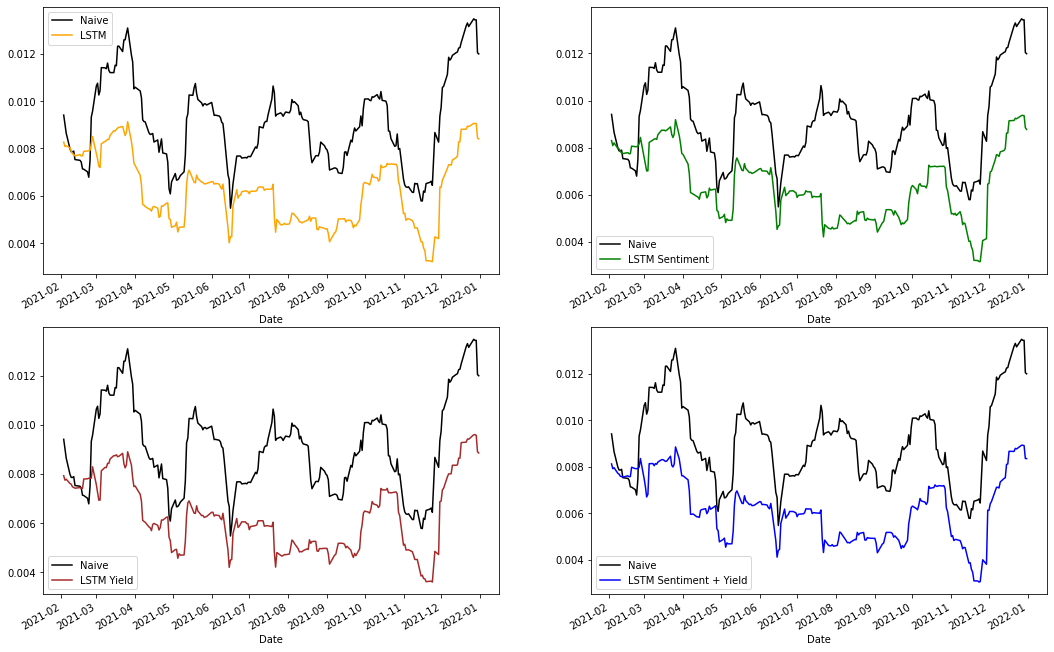

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
vol_naive.plot(ax=ax[0, 0], color='black')
vol_naive.plot(ax=ax[0, 1], color='black')
vol_naive.plot(ax=ax[1, 0], color='black')
vol_naive.plot(ax=ax[1, 1], color='black')

vol_lstm.plot(ax=ax[0, 0], color='orange')
vol_sent.plot(ax=ax[0, 1], color='green')
vol_yield.plot(ax=ax[1, 0], color='brown')
vol_comb.plot(ax=ax[1, 1], color='blue')

ax[0, 0].legend(['Naive', 'LSTM'])
ax[0, 1].legend(['Naive', 'LSTM Sentiment'])
ax[1, 0].legend(['Naive', 'LSTM Yield'])
ax[1, 1].legend(['Naive', 'LSTM Sentiment + Yield'])

# Multivariate GARCH

In [61]:
ccc_cov = np.load('outputs/CCC/ccc_covariance.npy')[-len(y_test):]
dcc_cov = np.load('outputs/DCC/dcc_covariance.npy')[-len(y_test):]

ccc_cov.shape, dcc_cov.shape, y_test.shape

((251, 12, 12), (251, 12, 12), (251, 78))

In [63]:
ccc_vec, dcc_vec = decompose_covariance(ccc_cov), decompose_covariance(dcc_cov)
ccc_mse = mse(y_test, ccc_vec)
dcc_mse = mse(y_test, dcc_vec)

ccc_mse, dcc_mse

(0.0005549337617570237, 0.0001896767726754708)

In [65]:
ccc_port = Portfolio(r_test, ccc_cov)
dcc_port = Portfolio(r_test, dcc_cov)

print('CCC Portfolio:')
ccc_port.optimize()
ccc_port.metrics(plot_history=False)
print()
print('DCC Portfolio:')
dcc_port.optimize()
dcc_port.metrics(plot_history=False)

CCC Portfolio:
Final Portfolio Value: $124.2
Overall Return (%): 24.19
Sharpe Ratio: 1.66
Sortino Ratio: 2.28

DCC Portfolio:
Final Portfolio Value: $118.5
Overall Return (%): 18.49
Sharpe Ratio: 1.69
Sortino Ratio: 2.2
